## Ensemble Methods

#### *11 November 2020*

#### *DATA 1010*

Today, we will learn two techniques to improve the performance of our ML models:

**Bagging (*B*ootstrap *Ag*gregation):** Instead of training one model, we train multiple models and aggregate their predictions (by majority voting for classifiers or averaging for regressors) to compute the final predicted outcome. To make each model different, we can either train on random subset of the data (chosen with replacement) or on a random set of features.

**Boosting:** We train multiple models in such a ways that each model addresses deficiences of the other models. We will look at two popular approaches for boosting, *AdaBoost* and *Gradient Boosting*. Adaboost gives troublesome training points extra *weight* and trains models with those weights, while gradient boosting fits the *difference* between training response values and values predicted by previous models.

In [1]:
import Pkg; Pkg.add("XGBoost"); Pkg.add("ScikitLearn"); Pkg.add("DecisionTree")

  Resolving package versions...
  Installed XGBoost_jll ─ v1.2.0+0
  Installed XGBoost ───── v1.1.1
######################################################################### 100.0%
Updating `~/problem-sets/Project.toml`
  [009559a3] + XGBoost v1.1.1
Updating `~/problem-sets/Manifest.toml`
  [009559a3] + XGBoost v1.1.1
  [a5c6f535] + XGBoost_jll v1.2.0+0
  Resolving package versions...
No Changes to `~/problem-sets/Project.toml`
No Changes to `~/problem-sets/Manifest.toml`
  Resolving package versions...
No Changes to `~/problem-sets/Project.toml`
No Changes to `~/problem-sets/Manifest.toml`


In [2]:
using CSV, Plots, LaTeXStrings, DecisionTree, DataFrames, XGBoost, StatsBase
gr(fontfamily = "Palatino");

┌ Info: Precompiling XGBoost [009559a3-9522-5dbb-924b-0b6ed2b22bb9]
└ @ Base loading.jl:1278


--- 

## Problem 1

Give an example of a technique in mathematics where we approximate a function by adding a sequence of functions, each of which is chosen to make the running sum of itself and the previous ones as close as possible to the target function.

Taylor series: 

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-6798115109962275056\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16527888630385634728\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-6798115109962275056\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

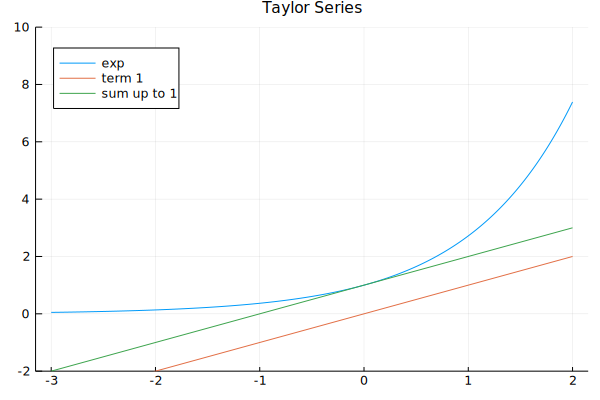

In [3]:
using Interact
# @manipulate for n in 0:8
n = 1
plot(-3:0.01:2, exp, label = "exp", ylims = (-2,10), legend = :topleft, title = "Taylor Series", titlefontsize = 10)
    plot!(-3:0.01:2, x -> x^n/factorial(n), label = "term $n")
    plot!(-3:0.01:2, x -> sum(x^k/factorial(k) for k in 0:n), label = "sum up to $n")
# end

---

# Bagging

## Problem 2

Consider $Y_1,\cdots,Y_n$, identically distributed random variables with variance $\operatorname{Var}(Y_i) = \sigma^2$ and pairwise correlation $\rho > 0$. Show that:

$$ \operatorname{Var}\Big( \frac{1}{n} \sum_{i=1}^n Y_i \Big) = \rho\sigma^2 + \frac{1-\rho}{n}\sigma^2 $$

How does this formula relate to the idea of bagging? Using the formula, show that bagging improves performance by reducing overfitting.

*Hint:* Assume $Y_i$ is the prediction made by the $i^\text{th}$ model.


We have:

$$ \operatorname{Var}\Big(\sum_{i=1}^n Y_i \Big) = \operatorname{Cov}\Big(\sum_{i=1}^n Y_i, \sum_{i=1}^n Y_i \Big) = \sum_{i=1}^n \operatorname{Var}(Y_i) + \sum_{i \ne j} \operatorname{Cov}(Y_i,Y_j) = n \operatorname{Var}(Y_i) + n(n-1)\operatorname{Cov}(Y_i,Y_j) $$

Therefore,

$$ \operatorname{Var}\Big(\frac{1}{n} \sum_{i=1}^n Y_i \Big) = \frac{1}{n^2} (n\sigma^2 + n(n-1)\rho\sigma^2) = \rho\sigma^2 + \frac{1-\rho}{n}\sigma^2$$

The variance of the aggregate is smaller than $\sigma^2$ for $n > 1$ and $0 < \rho < 1$. We expect some correlation between the predicted outcomes of the trained models (since they are trained on samples drawn from the same training data) but it unlikely that $\rho = 1$. 

We have shown that aggregation reduces variance. Overfitting is usually characterized by low bias and high variance. By reducing variance, bagging can reduce overfitting.

---

## Problem 3

Consider the following simulated dataset. The horizontal axis represents the (one-dimensional) feature vector, and the vertical axis represents the response variable.

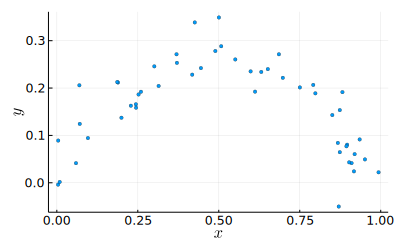

In [4]:
using Plots, DecisionTree
n = 50
X = rand(n,1)
y = [x - x^2 + 0.05randn() for x in X[:]]
p = scatter(X[:], y, size = (400,250), xlabel = L"x", ylabel = L"y",
            label = "", ms = 2, msw = 0.5) # markersize and markerstrokewidth

Fit these data with bagged decision trees. Run the code block several times to get a sense of how much variance you get in the resulting predictions. 

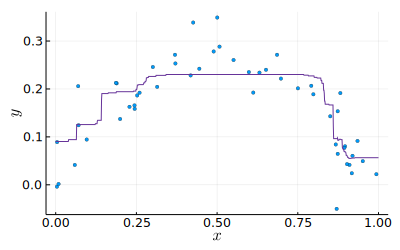

In [5]:
N = 100
models = [DecisionTreeRegressor(max_depth=2) for _ in 1:N]
for i in 1:N
    inds = sample(1:size(X,1),50) 
    DecisionTree.fit!(models[i], X[inds,:], y[inds]) 
end
plot!(p, 0:0.001:1, x -> mean(DecisionTree.predict(model, [x]) for model in models), label = "", color = :rebeccapurple)

---

## Problem 4

*Adaboost*ing weights the points according to how we'll they've been fit by the models we've trained so far.



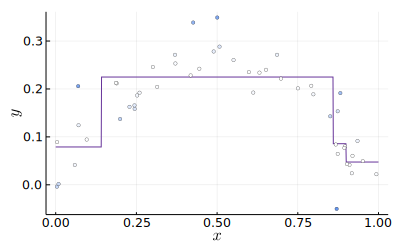

In [6]:
model = DecisionTreeRegressor(max_depth=2) 
DecisionTree.fit!(model, X, y)
plot(0:0.001:1, x -> DecisionTree.predict(model, [x]), label = "", color = :rebeccapurple)
scatter!(X[:], y, size = (400,250), xlabel = L"x", ylabel = L"y", color = cgrad([:white, :cornflowerblue]), 
            colorbar = false, label = "", ms = 2, msw = 0.5, marker_z = (y .- DecisionTree.predict(model, X)).^2)

To Adaboost a given model, the model itself must be able to accommodate weights for the training points. How can we alter the decision tree training process to give points priority in proportion to a given choice of weight for each point? Provide an answer for both regression and classification.

## Problem 5

Now let's look at *gradient* boosting for the same dataset.

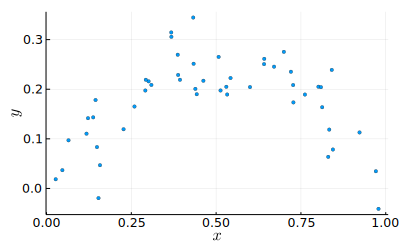

In [7]:
using Plots, DecisionTree
n = 50
X = rand(n,1)
y = [x - x^2 + 0.05randn() for x in X[:]]
scatter(X[:], y, size = (400,250), xlabel = L"x", ylabel = L"y", label = "", ms = 2, msw = 0.5) # markersize and markerstrokewidth

Execute the code cells below to illustrate how gradient boosted decision trees fit this data.

In [8]:
model₁ = DecisionTreeRegressor(max_depth=2)
model₂ = DecisionTreeRegressor(max_depth=2)
model₃ = DecisionTreeRegressor(max_depth=2)
 
DecisionTree.fit!(model₁, X, y)
y₁ = DecisionTree.predict(model₁, X)
DecisionTree.fit!(model₂, X, y - y₁)
y₂ = DecisionTree.predict(model₂, X)
DecisionTree.fit!(model₃, X, y - y₁ - y₂);
r̂(x) = sum(DecisionTree.predict(model, [x]) for model in (model₁, model₂, model₃))

r̂ (generic function with 1 method)

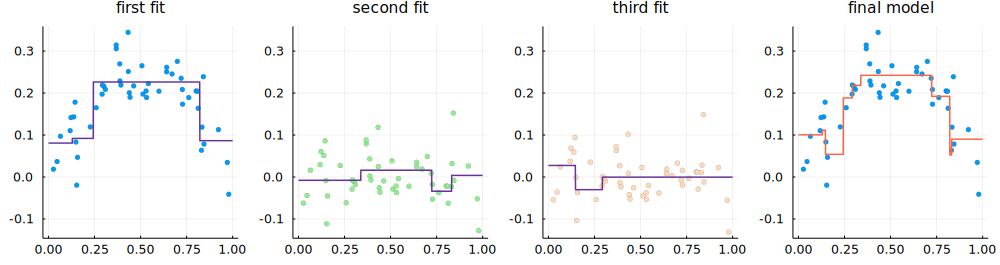

In [9]:
p1 = scatter(X[:], y, title = "first fit", label = "")
plot!(p1, 0:0.001:1, x->DecisionTree.predict(model₁, [x]), label = "", color = :rebeccapurple)
p2 = scatter(X[:], y - y₁, title = "second fit", label = "", color = :lightgreen)
plot!(p2, 0:0.001:1, x->DecisionTree.predict(model₂, [x]), label = "", color = :rebeccapurple)
p3 = scatter(X[:], y - y₁ - y₂, title = "third fit", label = "", color = :peachpuff)
plot!(p3, 0:0.001:1, x->DecisionTree.predict(model₃, [x]), label = "", color = :rebeccapurple)
p4 = scatter(X[:], y, label = "")
plot!(p4, 0:0.001:1, r̂, title = "final model", label = "", color = :tomato)
plot(p1, p2, p3, p4, layout = (1,4), size = (1000, 265), link = :y, ms = 3, msw=0.2, lw = 1.5, titlefontsize=10)

(a) Explain why the green points in the second figure have largely shifted down relative to the blue points in the first picture. 

(b) What is the relationship between the three purple curves and the final tomato curve?

(c) Gradient boosting for decision trees is pretty similar to simply increasing the depth of the tree. How is it different?

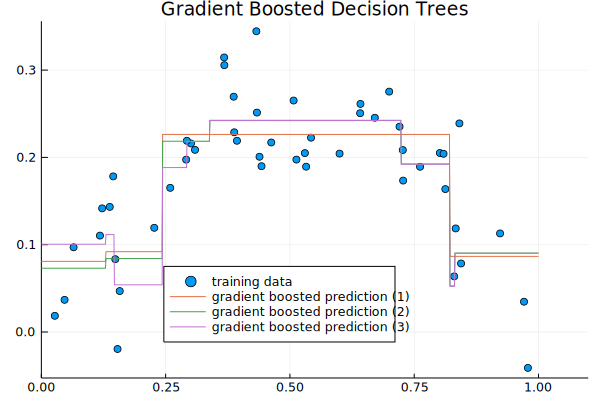

In [10]:
r̂₁(x) = sum(DecisionTree.predict(m, [x]) for m in (model₁,))
r̂₂(x) = sum(DecisionTree.predict(m, [x]) for m in (model₁, model₂))
r̂₃(x) = sum(DecisionTree.predict(m, [x]) for m in (model₁, model₂, model₃))

scatter(X[:], y, label = "training data", legend = :bottom, fontfamily = "Palatino")
plot!(0:0.001:1, r̂₁, label = "gradient boosted prediction (1)")
plot!(0:0.001:1, r̂₂, label = "gradient boosted prediction (2)")
plot!(0:0.001:1, r̂₃, label = "gradient boosted prediction (3)", size = (600, 400), xlims = (0, 1.1), 
      title = "Gradient Boosted Decision Trees", titlefontsize = 12)

---

## Problem 6

Finally, let's look at a healthcare dataset on hospital readmissions for patients with diabetes. Hospital readmissions within 30 days after discharge account for over $\$17$ billion in avoidable Medicare expenditures in the US, and they are associated with poor prognosis for patients. Source: [New England Journal of Medicine](https://www.nejm.org/doi/10.1056/NEJMsa1513024)

Let us load and explore this data:

In [11]:
df = CSV.read("diabetic_data.csv")
df = df[:, [:num_medications, :number_diagnoses, :num_lab_procedures,:readmitted]]
#:time_in_hospital, :admission_type_id, :discharge_disposition_id, :admission_source_id, :readmitted]]
df[!,:readmitted] = [x == "NO" for x in df[:,:readmitted]]
first(df, 5)

,num_medications,number_diagnoses,num_lab_procedures,readmitted
,Int64,Int64,Int64,Bool
1,1,1,41,1
2,18,9,59,0
3,13,6,11,1
4,16,7,44,1
5,8,5,51,1


(a) Check what proportion of patients in the dataset are readmitted:

In [13]:
# proportionmap(labels)

*Cross-validation* means testing the data on a witheld subset of the training data, called **validation** data. Julia provides an interface to perform cross validation which conforms to the ScikitLearn approach. 

In [14]:
using ScikitLearn.CrossValidation: cross_val_score

┌ Info: Precompiling ScikitLearn [3646fa90-6ef7-5e7e-9f22-8aca16db6324]
└ @ Base loading.jl:1278


In [15]:
features = convert(Matrix, df[:, 1:end-1])
labels = df[:,:readmitted]

model = RandomForestClassifier(max_depth=10)
cross_val_score(model, features, labels; cv=5)

5-element Array{Float64,1}:
 0.5478530018669548
 0.5750712390684878
 0.5365793740480519
 0.5356458507345354
 0.5389150943396226

---

*XGBoost* is the LIBSVM of gradient boosting: it's been finely tuned for strong performance results, and it's callable from Julia, Python, R, MATLAB, Octave, Java, Ruby, C, and C++. Let's apply XGBoost to this medical dataset.

In [16]:
n_rounds = 3
bst = xgboost(features, n_rounds, label = labels, eta = 1, objective="binary:logistic", max_depth = 10)

[1]	train-error:0.429456
[2]	train-error:0.424759
[3]	train-error:0.422990


Booster(Ptr{Nothing} @0x000000000a2b7d50)

In [18]:
# training error:
sum((XGBoost.predict(bst, features) .> 0.5) .== labels) / length(labels)

0.577010003340998

In [19]:
# cross-validation
nfold = 5
param = ["max_depth" => 2,
         "eta" => 1,
         "objective" => "binary:logistic"]
metrics = ["error"]
nfold_cv(features, n_rounds, nfold, label = labels, param = param, metrics = metrics)

[1]	cv-test-error:0.456931+0.002667	cv-train-error:0.456493+0.001922
[2]	cv-test-error:0.447812+0.002331	cv-train-error:0.445198+0.000451
[3]	cv-test-error:0.446495+0.001979	cv-train-error:0.442719+0.001149


---

## Problem 7 (Challenge)

Copy the decision tree code from last class and make suitable changes to accommodate weights for the training points. Use the resulting model to apply Adaboost to the parabola-shaped data we studied above.